### Final Model Training
Chase Kent-Dotson  
April 4, 2022

### Introduction
This notebook contains the final construction and training of my most predictively powerful model. I will approach my final push towards a best model by first scoring previous models trained, then by training a new top layer and finally fine tuning the model to improve accuracy.  

### Table of Contents:
* [Previous Model Evaluation in Preparation for Final Model](#1)
* [Final Model with Newly Trained Top Layer](#2)
* [Final Model without Added Top Layer Dropout](#3)
* [Final Training Analysis](#4)
* [Conclusion](#5)

### Imports

In [2]:
# data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# image file handling
from PIL import Image
import cv2

# file directory interface
import os.path, sys

# transfer learning modeling
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras import Model
import efficientnet.tfkeras as efn

# model evaluation
from sklearn.metrics import classification_report

# data generation for modeling
from keras.preprocessing.image import ImageDataGenerator

### Previous Model Evaluation in Preparation for Final Model <a class="anchor" id="1"></a>
Below I will load and evaluate some of the models I have previously built and trained to help guide the process of building and training my final model.

In [14]:
# set variables for data preparation and augmentation
img_size = (224,224)
batch_size = 32
num_classes = 196

In [1]:
# Data agumentation function
def augment_data(img_size, batch_size=32, num_classes=196):
    '''
    Prepares all data generators for train, validation, and test data
    
    Parameters
    ----------
    img_size: tuple designating image resolution, use (224,224) for EfficientNetB0
    batch_size: the number of images to be processed and trained at once, default 32
    num_classes: the number of classes in the data, default 196 for this dataset
    
    Returns
    -------
    ret: a tuple containing the following:
        train_datagen: the data generator for the train set
        test_datagen: the data generator for the test set
        train_data: the flow from directory call for retrieving train images
        validation_data: the flow from directory call for retrieving validation images
        test_data: the flow from directory call for retrieving test images
    
    '''
    
    # data generator with a 1/255 rescale, +-20% random shear and zoom, and a random binary flip
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       samplewise_std_normalization=True,
                                       samplewise_center=True,
                                       validation_split=0.2)

    # no random augmentations to the test data
    test_datagen = ImageDataGenerator(rescale=1./255,
                                      samplewise_std_normalization=True,
                                      samplewise_center=True)

    # generate the data for the train set including automatic labels from file structure
    train_data = train_datagen.flow_from_directory('data/car_data/car_data/train',
                                                  target_size=img_size,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  subset='training')

    # generate the validation data from the portion set aside earlier
    validation_data = train_datagen.flow_from_directory('data/car_data/car_data/train',
                                                        target_size=img_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        subset='validation') 

    # generate data for the test set
    test_data = test_datagen.flow_from_directory('data/car_data/car_data/test',
                                                  target_size=img_size,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)
    
    return (train_datagen, test_datagen, train_data, validation_data, test_data)

In [17]:
# call the data augmentation funtion to prepare the images
train_datagen, test_datagen, train_data, validation_data, test_data = augment_data(img_size)

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [8]:
# load transfer model model 1 for evaluation
reconstructed_model = keras.models.load_model('models/transfer_model_B0_1')

In [9]:
# Evaluate the model's performance on the test data
score = reconstructed_model.evaluate(test_data, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

252/252 [==============================] - 231s 908ms/step - loss: 1.6262 - acc: 0.6513
Test loss: 1.6261944770812988
Test accuracy: 0.6512871384620667


In [10]:
# load transfer model 2 for evaluation
reconstructed_model = keras.models.load_model('models/transfer_model_B0_lr001')

In [11]:
# Evaluate the model's performance on the test data
score = reconstructed_model.evaluate(test_data, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

252/252 [==============================] - 236s 928ms/step - loss: 1.0135 - acc: 0.7346
Test loss: 1.013504147529602
Test accuracy: 0.7346101403236389


In [18]:
# set variables for data augmentation
img_size = (240,240)
batch_size = 32
num_classes = 196

In [19]:
# call the data augmentation funtion to prepare the images
train_datagen, test_datagen, train_data, validation_data, test_data = augment_data(img_size)

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [20]:
# load transfer model 3 for evaluation
reconstructed_model = keras.models.load_model('models/transfer_model_B1_1')

In [21]:
# Evaluate the model's performance on the test data
score = reconstructed_model.evaluate(test_data, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

252/252 [==============================] - 383s 2s/step - loss: 1.4826 - acc: 0.6660
Test loss: 1.4826449155807495
Test accuracy: 0.6659619212150574


In [25]:
# set variables for data augmentation
img_size = (224,224)
batch_size = 32
num_classes = 196

### Previous Model Evaluation in Preparation for Final Model: Findings 
After attempting many different models including a CNN from scratch and various versions of Efficientnet, EggicientNetB0 won out as it provided comparable accuracy to B1 with a far shorter training times which allowed me to iterate faster when tuning the model. Keras states [here](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) that larger, more complex variants of EfficientNet (B1-B7) do not guarantee improved performance, which was my experience in using them with this dataset.  
  
Like all neural networks, every model I tried is susceptible to overfitting. In an attempt to combat the effect and allow for further training to continue to improve accuracy, I tested a number of different learning rates with each of the models. The best performing model was the EfficientNetB0 with a learning rate of 0.001 (default for the Adam optimizer) after 20 epochs, out performing both the more complex B1 variant and the B0 model trained for 60 epochs with a lower learning rate of 0.0001.  
  
To create a final model, further research into the EfficientNet documentation showed I would need to train the output layers as I had been in intital testing, then train the entire model for fine tuning. For the fine tuning step I decided to use a much lower learning rate than any of my previous tests: 0.00001. As is noted in the Keras documentation [here](https://keras.io/guides/transfer_learning/), there is substantial risk of quick overfitting with a complex model that is completely unfrozen, in this case over 4 million trainable parameters. My final model will use this 2-step training process, using either a new EfficientNetB0 and top layer combination with an added dropout layer external to the base model, or the original best performing test which did not contain the dropout layer when initially trained.

### Final Model with Newly Trained Top Layer <a class="anchor" id="2">
Below I build a new top layer for the EfficientNetB0 base model and train it for 20 epochs with the base model frozen, then unfreeze the base model and fine tune the entire model for another 10 epochs.

In [26]:
# call the data augmentation funtion to prepare the images
train_datagen, test_datagen, train_data, validation_data, test_data = augment_data(img_size)

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [34]:
# set up the model for training
base_model = efn.EfficientNetB0(weights='imagenet', include_top=False)
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x) # <--- added dropout layer between the top layer and the base model
predictions = Dense(len(train_data.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [35]:
# set up the history variable and train the non-base components of the model
history = model.fit_generator(generator=train_data,
                              steps_per_epoch=train_data.samples // batch_size,
                              validation_data=validation_data,
                              validation_steps=validation_data.samples // batch_size,
                              epochs=20,                           
                              workers=8,             
                              max_queue_size=32,             
                              verbose=1)

Epoch 1/20
206/206 [==============================] - 273s 1s/step - loss: 4.4394 - acc: 0.1223 - val_loss: 3.5999 - val_acc: 0.2669
Epoch 2/20
206/206 [==============================] - 262s 1s/step - loss: 3.1608 - acc: 0.3619 - val_loss: 2.9336 - val_acc: 0.4108
Epoch 3/20
206/206 [==============================] - 244s 1s/step - loss: 2.5324 - acc: 0.5091 - val_loss: 2.5732 - val_acc: 0.4714
Epoch 4/20
206/206 [==============================] - 224s 1s/step - loss: 2.1303 - acc: 0.5816 - val_loss: 2.3205 - val_acc: 0.5046
Epoch 5/20
206/206 [==============================] - 224s 1s/step - loss: 1.8565 - acc: 0.6407 - val_loss: 2.1429 - val_acc: 0.5163
Epoch 6/20
206/206 [==============================] - 221s 1s/step - loss: 1.6308 - acc: 0.6887 - val_loss: 2.0131 - val_acc: 0.5495
Epoch 7/20
206/206 [==============================] - 223s 1s/step - loss: 1.4469 - acc: 0.7199 - val_loss: 1.8894 - val_acc: 0.5781
Epoch 8/20
206/206 [==============================] - 222s 1s/step - 

In [38]:
# save the model history
np.save('history/efn_B0_top_layer_hist.npy', history.history)

In [39]:
# save the model
model.save('models/transfer_model_B0_top_layer')

INFO:tensorflow:Assets written to: models/transfer_model_B0_top_layer\assets


C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [40]:
# unfreeze the entire model except the batch normalization layers
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

# compile the model with a low learning rate for fine tuning
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [41]:
# set up the history variable and fine tune the entire model
fine_tune_history = model.fit_generator(generator=train_data,
                              steps_per_epoch=train_data.samples // batch_size,
                              validation_data=validation_data,
                              validation_steps=validation_data.samples // batch_size,
                              epochs=10,                           
                              workers=8,             
                              max_queue_size=32,             
                              verbose=1)

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
206/206 [==============================] - 940s 4s/step - loss: 0.3905 - acc: 0.9182 - val_loss: 1.1942 - val_acc: 0.6979
Epoch 2/10
206/206 [==============================] - 1002s 5s/step - loss: 0.3087 - acc: 0.9359 - val_loss: 1.1434 - val_acc: 0.6947
Epoch 3/10
206/206 [==============================] - 982s 5s/step - loss: 0.2667 - acc: 0.9400 - val_loss: 1.1252 - val_acc: 0.7038
Epoch 4/10
206/206 [==============================] - 901s 4s/step - loss: 0.2385 - acc: 0.9473 - val_loss: 1.0978 - val_acc: 0.7129
Epoch 5/10
206/206 [==============================] - 849s 4s/step - loss: 0.2156 - acc: 0.9488 - val_loss: 1.0795 - val_acc: 0.7227
Epoch 6/10
206/206 [==============================] - 863s 4s/step - loss: 0.1982 - acc: 0.9514 - val_loss: 1.0187 - val_acc: 0.7298
Epoch 7/10
206/206 [==============================] - 859s 4s/step - loss: 0.1781 - acc: 0.9584 - val_loss: 1.0555 - val_acc: 0.7344
Epoch 8/10
206/206 [==============================] - 934s 5s/step -

In [42]:
# save the model history
np.save('history/efn_B0_fine_tune_hist.npy', fine_tune_history.history)

In [43]:
# save the model
model.save('models/transfer_model_B0_fine_tune')

INFO:tensorflow:Assets written to: models/transfer_model_B0_fine_tune\assets


C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [3]:
def plot_evaluation_metrics(history, display_name, file_name):
    '''
    Plots the accuraccy and loss for training and test sets on two subplots
    
    Parameters
    ----------
    history: a dictionary containing the training history
    display_name: the name for the training session to be applied to plot titles
    file_name: the name for the file, must contain file type suffix
    
    Returns
    -------
    ret: none
    
    '''
    # assert types for all parameters
    assert isinstance(history, dict), 'history must be a dictionary'    
    assert isinstance(display_name, str), 'display_name must be a string' 
    assert isinstance(file_name, str), 'file_name must be a string' 
    
    # visualize top layer model training
    plt.subplots(1,2, figsize=(15,5))

    # plot the accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title(f'{display_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch Number')
    plt.legend(['train', 'validation'], loc='upper left')


    # plot the loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(f'{display_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch Number')
    plt.legend(['train', 'validation'], loc='upper left')

    # save the image for use in slides
    plt.savefig(f'report_pics/{file_name}', bbox_inches = "tight", dpi=300)

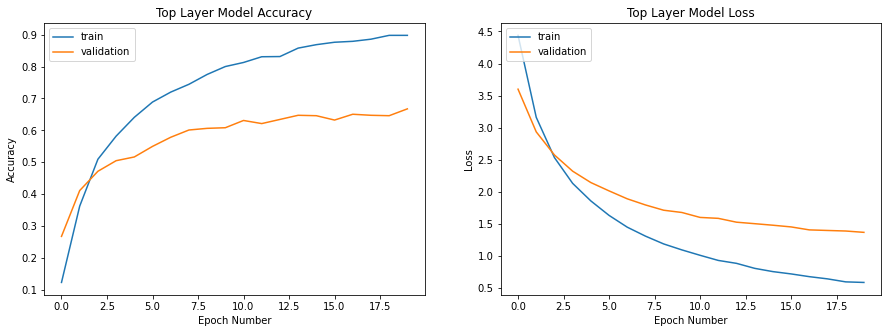

In [4]:
# Note: the line of code below allows for a saved history to be loaded for plotting
# using the plot_evaluation_metrics function. To use the function directly
# after training a model, this line should be commented out and the first argument
# of the function call should be changed to history.history as the function expects a dictionary
history = np.load('history/efn_B0_top_layer_hist.npy', allow_pickle='TRUE').item()

# change history to history.history if NOT loading from a previously saved history
plot_evaluation_metrics(history, 'Top Layer', 'top_layer_training_1.tif')

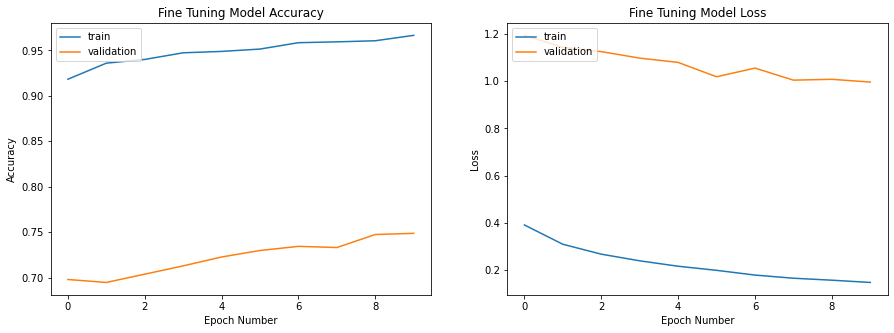

In [5]:
# load the history for the first fine tuning attempt
history = np.load('history/efn_B0_fine_tune_hist.npy', allow_pickle='TRUE').item()

# change history to history.history if NOT loading from a previously saved history
plot_evaluation_metrics(history, 'Fine Tuning', 'fine_tuning_training_1.tif')

In [54]:
# Evaluate the model's performance on the test data
score = model.evaluate(test_data, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

252/252 [==============================] - 199s 790ms/step - loss: 0.9638 - acc: 0.7497
Test loss: 0.9637779593467712
Test accuracy: 0.7496579885482788


### Final Model with Newly Trained Top Layer: Findings
20 epochs of training on the EfficientNetB0 with a default learning rate and a dropout layer added yielded good results, but not better than prievious training of the same layers without the dropout layer. After fine tuning of the entire model, however, the final test set accuraccy was better than any previous model at <b>74.97%</b>.  
  
Visualizing the accuracy and loss values for training and fine tuning shows that while there is separation between the validation and training values, the validation metrics are not poor by any means and their trend in both accuracy and loss has slowed but not begun to drift in the wrong direction, meaning the model has continued to generalize from the features available in the training data.  
  
In my research, I discovered an important note about handling the Batch Normailization layers when unfreezing layers of a large model for fine tuning [here](https://keras.io/guides/transfer_learning/). It says that the Batch Normalization layers must be kept in an untrainable state when unfreezing other layers in order to maintain the representations learned by the model in initial training. I have made sure to include code for handling these layers properly. 

### Final Model without Added Top Layer Dropout <a class="anchor" id="3">
Below I will fine tune a complete model with the same construction as above, but using the previously trained older version of the top layer without the added dropout layer. 

In [57]:
# load transfer model 2 for evaluation
reconstructed_model = keras.models.load_model('models/transfer_model_B0_lr001')

In [59]:
# unfreeze the entire model except the batch normalization layers
for layer in reconstructed_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

# compile the model with a low learning rate for fine tuning
reconstructed_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
                            loss='categorical_crossentropy', 
                            metrics=['acc'])

reconstructed_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [61]:
# set up the history variable and fine tune the entire model
fine_tune_history_2 = reconstructed_model.fit_generator(generator=train_data,
                                          steps_per_epoch=train_data.samples // batch_size,
                                          validation_data=validation_data,
                                          validation_steps=validation_data.samples // batch_size,
                                          epochs=10,                           
                                          workers=8,             
                                          max_queue_size=32,             
                                          verbose=1)

Epoch 1/10
206/206 [==============================] - 894s 4s/step - loss: 0.1245 - acc: 0.9776 - val_loss: 0.9913 - val_acc: 0.7363
Epoch 2/10
206/206 [==============================] - 1198s 6s/step - loss: 0.0860 - acc: 0.9814 - val_loss: 1.0244 - val_acc: 0.7474
Epoch 3/10
206/206 [==============================] - 1027s 5s/step - loss: 0.0732 - acc: 0.9837 - val_loss: 0.9847 - val_acc: 0.7539
Epoch 4/10
206/206 [==============================] - 1048s 5s/step - loss: 0.0596 - acc: 0.9866 - val_loss: 1.0364 - val_acc: 0.7422
Epoch 5/10
206/206 [==============================] - 923s 4s/step - loss: 0.0580 - acc: 0.9842 - val_loss: 1.0165 - val_acc: 0.7461
Epoch 6/10
206/206 [==============================] - 1041s 5s/step - loss: 0.0520 - acc: 0.9872 - val_loss: 1.0758 - val_acc: 0.7337
Epoch 7/10
206/206 [==============================] - 1040s 5s/step - loss: 0.0459 - acc: 0.9889 - val_loss: 1.0508 - val_acc: 0.7448
Epoch 8/10
206/206 [==============================] - 961s 5s/st

In [62]:
# save the model history
np.save('history/efn_B0_fine_tune_hist_2.npy', fine_tune_history_2.history)

In [63]:
# save the model
reconstructed_model.save('models/transfer_model_B0_fine_tune_2')

INFO:tensorflow:Assets written to: models/transfer_model_B0_fine_tune_2\assets


C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


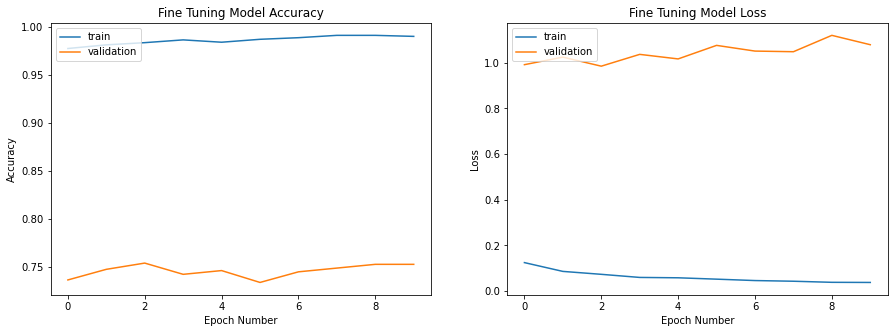

In [6]:
# load the history for the fine tuning attempt on the model without added dropout
history = np.load('history/efn_B0_fine_tune_hist_2.npy', allow_pickle='TRUE').item()

# plot the accuracy and loss
plot_evaluation_metrics(history, 'Fine Tuning', 'fine_tuning_training_2.tif')

In [67]:
# Evaluate the model's performance on the test data
score = reconstructed_model.evaluate(test_data, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

252/252 [==============================] - 207s 820ms/step - loss: 1.0897 - acc: 0.7556
Test loss: 1.089678168296814
Test accuracy: 0.7556273937225342


### Final Model without Added Top Layer Dropout: Findings 
As suspected, after fine tuning the better scoring top layer, the resulting model is more accurate. Upon closer inspection, however, the news is not as good as it seems. The accuracy advantage over the first fine tuned model is minimal, and while the validation accuracy trend is mostly flat, the validation loss has begun increasing steadily as seen in the plot above.  
  
Given the stark contrast between the validation plot for this model and the validation plot of the fine tuning steps from the previous model, it seems the addition of the dropout layer helped to prevent some overtraining. This gives me confidence there is more to be gained by training the first model further.

### Final Training Analysis <a class="anchor" id="4">
Below I will attempt to squeeze out additional predictive power from the final model with the added dropout layer by continuing training, as this model was less susceptible to overfitting and thus is more likely to provide further improvements. 

In [71]:
# load previous model for further fine tuning
reconstructed_model = keras.models.load_model('models/transfer_model_B0_fine_tune')

In [72]:
# unfreeze the entire model except the batch normalization layers
for layer in reconstructed_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

# compile the model with a low learning rate for fine tuning
reconstructed_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
                            loss='categorical_crossentropy', 
                            metrics=['acc'])

reconstructed_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [73]:
# set up the history variable and fine tune the entire model
fine_tune_history_3 = reconstructed_model.fit_generator(generator=train_data,
                                          steps_per_epoch=train_data.samples // batch_size,
                                          validation_data=validation_data,
                                          validation_steps=validation_data.samples // batch_size,
                                          initial_epoch=10,
                                          epochs=20,                           
                                          workers=8,             
                                          max_queue_size=32,             
                                          verbose=1)

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 11/20
206/206 [==============================] - 892s 4s/step - loss: 0.1444 - acc: 0.9641 - val_loss: 0.9813 - val_acc: 0.7402
Epoch 12/20
206/206 [==============================] - 830s 4s/step - loss: 0.1312 - acc: 0.9665 - val_loss: 1.0029 - val_acc: 0.7507
Epoch 13/20
206/206 [==============================] - 1056s 5s/step - loss: 0.1302 - acc: 0.9671 - val_loss: 1.0100 - val_acc: 0.7435
Epoch 14/20
206/206 [==============================] - 1154s 6s/step - loss: 0.1142 - acc: 0.9720 - val_loss: 1.0111 - val_acc: 0.7396
Epoch 15/20
206/206 [==============================] - 1191s 6s/step - loss: 0.1134 - acc: 0.9729 - val_loss: 0.9926 - val_acc: 0.7513
Epoch 16/20
206/206 [==============================] - 1173s 6s/step - loss: 0.1078 - acc: 0.9723 - val_loss: 0.9750 - val_acc: 0.7572
Epoch 17/20
206/206 [==============================] - 1015s 5s/step - loss: 0.1029 - acc: 0.9735 - val_loss: 0.9743 - val_acc: 0.7611
Epoch 18/20
206/206 [==============================] - 11

In [74]:
# save the model history
np.save('history/efn_B0_fine_tune_hist_3.npy', fine_tune_history_3.history)

In [75]:
# save the model
reconstructed_model.save('models/transfer_model_B0_fine_tune_20_epoch')

INFO:tensorflow:Assets written to: models/transfer_model_B0_fine_tune_20_epoch\assets


C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


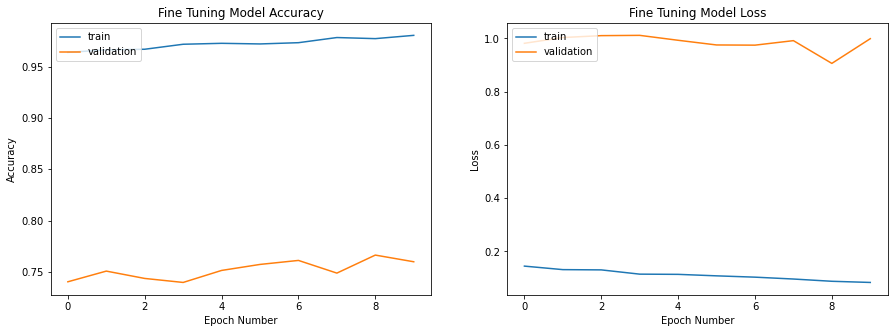

In [7]:
# load the history for the fine tuning attempt on the model without added dropout
history = np.load('history/efn_B0_fine_tune_hist_3.npy', allow_pickle='TRUE').item()

# plot the accuracy and loss
plot_evaluation_metrics(history, 'Fine Tuning', 'fine_tuning_training_3.tif')

In [76]:
# Evaluate the model's performance on the test data
score = reconstructed_model.evaluate(test_data, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

252/252 [==============================] - 217s 861ms/step - loss: 0.9256 - acc: 0.7669
Test loss: 0.925615131855011
Test accuracy: 0.766944408416748


### Final Training Analysis: Findings
Further fine tuning of the model trained with an additional dropout layer did provide some improvements in predictive power. The model improved in test set accuracy by <b>1.72%</b> and pulled ahead of the fine tuned model without the added dropout layer by <b>1.13%</b>. While there were improvements in accuracy, the loss value in validation remained nearly the same. Further attempts to fine tune the model with all layers unfrozen could lead to overfitting. 

### Conclusion <a class="anchor" id="5">
First I tested models previously trained to help guide my decision in choosing the best parameters for the top layer of my final model. After training that top layer, it was less accurate than a previous top layer I had trained, the only difference between the two being the addition of a dropout layer between the base model and the top layer. I decided to fine tune two models in parallel, one using each previously trained top layer. After fine tuning, the more accurate top layer did retain its accuracy advantage, but showed worse trends in its validation metrics. The model which did include the dropout layer during initial training showed more promising validation metrics, and was fine tuned further for additional accuracy improvements, finally achieving the highest accuracy score of any model I have trained. In my next notebook, I will move on from training to a deeper evaluation of the best model through examining missclassifications and class-by-class evaluation metrics. 